# Brain Tumor Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/home/constructor/anaconda3/envs/DLG/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=da6787ce-12e0-4ef9-a678-1fd2f8c6c7dc
To: /home/constructor/gammer_exercises/DL_group_challenge/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:13<00:00, 11.5MB/s]


In [4]:
!pip install unzip

In [7]:
#!unzip brain_tumor.zip

/bin/bash: line 1: unzip: command not found


In [8]:
ls -l

total 152496
-rw-r--r-- 1 constructor constructor        50 Apr  4 10:17 Brain_Tumor_Detector_Helper.ipynb:Zone.Identifier
-rw-r--r-- 1 constructor constructor    348977 Apr  4 10:22 Brain_Tumor_Detector_gammer.ipynb
drwxr-xr-x 6 constructor constructor      4096 Apr  4 10:24 Testing/
drwxr-xr-x 6 constructor constructor      4096 Apr  4 10:29 Training/
-rw-r--r-- 1 constructor constructor 155791278 Apr  4 10:20 brain_tumor.zip


In [9]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

[sudo] password for constructor: 


In [11]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

/bin/bash: line 1: tree: command not found


In [12]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

/bin/bash: line 1: tree: command not found


## Load Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

2024-04-04 10:48:08.501292: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 10:48:08.526893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 10:48:08.526909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 10:48:08.527524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 10:48:08.531942: I tensorflow/core/platform/cpu_feature_guar

TF Version: 2.15.0


## Utility functions to create dataset generators

In [243]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [5]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


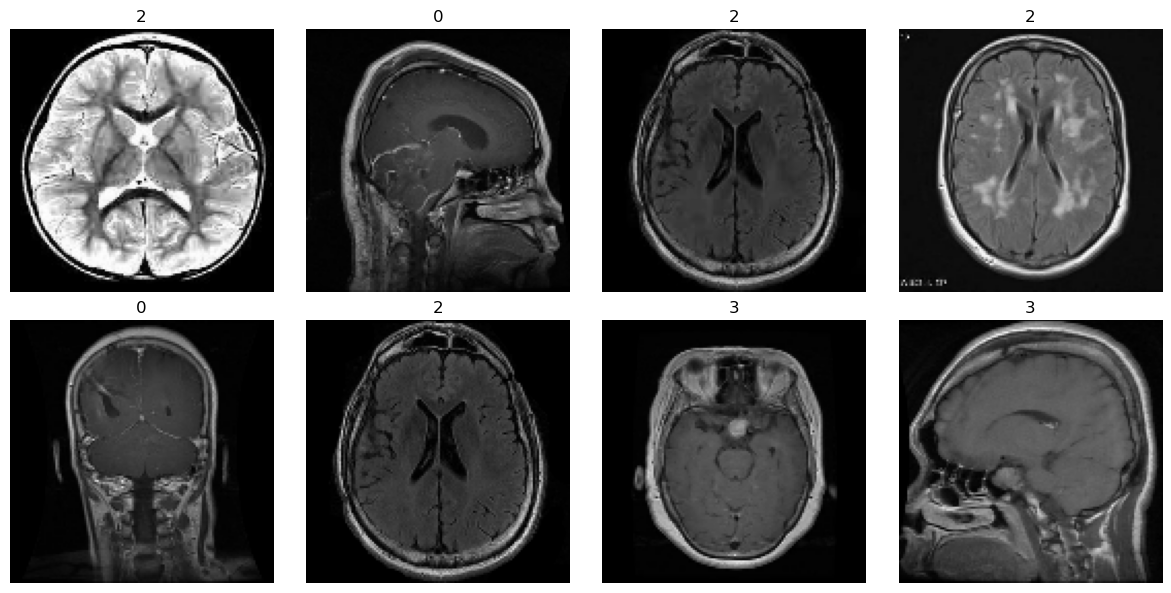

In [4]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [8]:
from tensorflow.keras import layers, models
from tensorflow import keras

## Create a simple baseline CNN model

In [77]:
model = models.Sequential()

model.add(layers.Conv2D(16, (8, 8), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (16, 16), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (16, 16), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

In [78]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 121, 121, 16)      3088      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 60, 60, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 45, 45, 32)        131104    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 7, 7, 64)          524352    
                                                                 
 flatten_8 (Flatten)         (None, 3136)            

In [79]:
model.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [80]:
%%time
history = model.fit(
                    train_ds,
                    epochs = 30,
                    validation_data = val_ds,
                    )

Epoch 1/30
143/143 [==============================] - 4s 18ms/step - loss: 2.4629 - sparse_categorical_accuracy: 0.5823 - val_loss: 0.5984 - val_sparse_categorical_accuracy: 0.7408
Epoch 2/30
143/143 [==============================] - 2s 17ms/step - loss: 0.5872 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.5028 - val_sparse_categorical_accuracy: 0.8109
Epoch 3/30
143/143 [==============================] - 2s 17ms/step - loss: 0.4396 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.4540 - val_sparse_categorical_accuracy: 0.8319
Epoch 4/30
143/143 [==============================] - 2s 17ms/step - loss: 0.3165 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.3926 - val_sparse_categorical_accuracy: 0.8529
Epoch 5/30
143/143 [==============================] - 2s 17ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.4451 - val_sparse_categorical_accuracy: 0.8739
Epoch 6/30
143/143 [==============================] - 2s 17ms/step - loss: 0.1771 - sparse_cate

In [69]:
y_true, y_pred = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 69ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:00<00:04,  2.09it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:00<00:01,  5.33it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:00<00:00,  7.35it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:00<00:00,  8.72it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:01<00:00,  9.70it/s]

1/1 [==============================] - 1s 976ms/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.81it/s]


In [70]:
y_pred_class = np.argmax(y_pred,1)

In [71]:
y_pred_class.shape

(1311,)

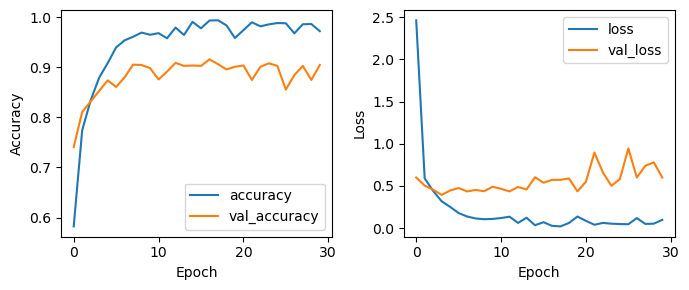

In [166]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.show()

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [75]:
class_names=['glioma', 'meningioma', 'notumor', 'pituitary']

In [76]:
print(classification_report(y_true, y_pred_class, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.87      0.77      0.82       300
  meningioma       0.73      0.58      0.64       306
     notumor       0.90      0.91      0.91       405
   pituitary       0.73      0.95      0.83       300

    accuracy                           0.81      1311
   macro avg       0.81      0.80      0.80      1311
weighted avg       0.81      0.81      0.81      1311



In [88]:
print(confusion_matrix(y_true, y_pred_class))

[[232  52   0  16]
 [ 31 176  38  61]
 [  1   6 370  28]
 [  4   7   3 286]]


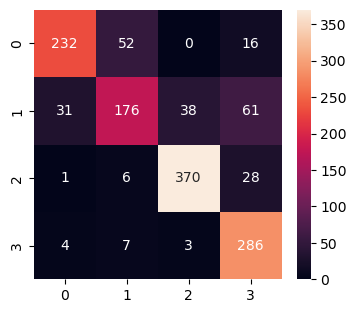

In [172]:
plt.subplots(figsize=(4,3.5))
sns.heatmap(confusion_matrix(y_true, y_pred_class), annot=True, fmt=".0f");
plt.show()

## Use EfficientNet Model

In [90]:
model_name = 'efficient_netV2S'

In [105]:
model_EN = tf.keras.applications.EfficientNetV2S(
                                                    include_top=False,
                                                    weights='imagenet',
                                                    input_tensor=None,
                                                    input_shape=IMG_SHAPE,
                                                    pooling=None,
                                                    classes=4,
                                                    classifier_activation='softmax',
                                                    include_preprocessing=True
                                                )

In [121]:
#model_EN.summary()

In [109]:
for layer in model_EN.layers[-10:]:
  print(layer.name)

block6o_se_reduce
block6o_se_expand
block6o_se_excite
block6o_project_conv
block6o_project_bn
block6o_drop
block6o_add
top_conv
top_bn
top_activation


In [129]:
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [130]:
last_conv_layer = model_EN.get_layer('top_activation')

conv_model = Model(inputs=model_EN.input,
                       outputs=last_conv_layer.output)

In [131]:
num_classes = 4

In [175]:
new_model = Sequential()
new_model.add(conv_model)
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [176]:
new_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 4, 4, 1280)        20331360  
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_28 (Dense)            (None, 4)                 5124      
                                                                 
Total params: 20336484 (77.58 MB)
Trainable params: 20182612 (76.99 MB)
Non-trainable params: 153872 (601.06 KB)
_________________________________________________________________


In [177]:
new_model.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [178]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min')

In [179]:
%%time
history_1 = new_model.fit(
                            train_ds,
                            epochs = 20,
                            validation_data = val_ds,
                            callbacks=[checkpoint]
                            )

Epoch 1/20


2024-04-04 13:27:44.904740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/model_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - ETA: 0s - loss: 0.0742 - sparse_categorical_accuracy: 0.9779

/home/constructor/anaconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 81s 205ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.9779 - val_loss: 0.2313 - val_sparse_categorical_accuracy: 0.9501
Epoch 2/20
143/143 [==============================] - 26s 178ms/step - loss: 0.0362 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.1838 - val_sparse_categorical_accuracy: 0.9536
Epoch 3/20
143/143 [==============================] - 26s 184ms/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.1407 - val_sparse_categorical_accuracy: 0.9667
Epoch 4/20
143/143 [==============================] - 26s 179ms/step - loss: 0.0459 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.1140 - val_sparse_categorical_accuracy: 0.9694
Epoch 5/20
143/143 [==============================] - 25s 173ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.1311 - val_sparse_categorical_accuracy: 0.9685
Epoch 6/20
143/143 [==============================] - 25s 174ms/step - loss: 0.0292 - sparse_cat

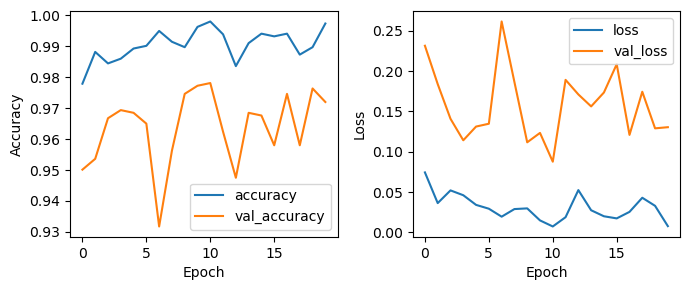

In [180]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_1.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_1.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_1.history['loss'], label='loss')
ax[1].plot(history_1.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.show()

In [181]:
y_true_1, y_pred_1 = eval_model_on_test(new_model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 3s 131ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:02<00:29,  2.91s/it]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:03<00:11,  1.32s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:03<00:06,  1.24it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:03<00:03,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:03<00:02,  2.31it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:03<00:01,  2.84it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:04<00:01,  3.31it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:04<00:00,  3.73it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:04<00:00,  4.07it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:04<00:00,  4.33it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.53it/s]


In [182]:
y_pred_1[0]

array([4.2931806e-05, 9.1364694e-07, 9.9995339e-01, 2.7635015e-06],
      dtype=float32)

In [183]:
y_pred_class_1 = np.argmax(y_pred_1,1)

In [184]:
print(classification_report(y_true, y_pred_class_1, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       300
  meningioma       0.97      0.95      0.96       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



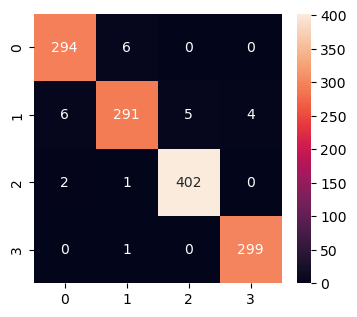

In [185]:
plt.subplots(figsize=(4,3.5))
sns.heatmap(confusion_matrix(y_true, y_pred_class_1), annot=True, fmt=".0f");
plt.show()

In [186]:
print(confusion_matrix(y_true, y_pred_class_1))

[[294   6   0   0]
 [  6 291   5   4]
 [  2   1 402   0]
 [  0   1   0 299]]


In [231]:
from sklearn.metrics import ConfusionMatrixDisplay

## Balance Class weights, do data augmentation and use Efficient Net

In [208]:
def eval_model_on_train(model):
    train_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(train_ds_1.take(100),
                             desc='Predicting on Train Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [209]:
y_true_train, y_pred_train = eval_model_on_train(new_model)

Found 5712 files belonging to 4 classes.


Predicting on Train Data:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Predicting on Train Data:   1%|▌                                                        | 1/100 [00:00<00:47,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Predicting on Train Data:   3%|█▋                                                       | 3/100 [00:00<00:18,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:   5%|██▊                                                      | 5/100 [00:00<00:12,  7.45it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:   7%|███▉                                                     | 7/100 [00:00<00:10,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


Predicting on Train Data:   9%|█████▏                                                   | 9/100 [00:01<00:09,  9.70it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  11%|██████▏                                                 | 11/100 [00:01<00:08, 10.43it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  13%|███████▎                                                | 13/100 [00:01<00:07, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


Predicting on Train Data:  15%|████████▍                                               | 15/100 [00:01<00:07, 11.19it/s]

1/1 [==============================] - 0s 32ms/step


Predicting on Train Data:  17%|█████████▌                                              | 17/100 [00:01<00:07, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  19%|██████████▋                                             | 19/100 [00:01<00:06, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


Predicting on Train Data:  21%|███████████▊                                            | 21/100 [00:02<00:06, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  23%|████████████▉                                           | 23/100 [00:02<00:06, 11.53it/s]

1/1 [==============================] - 0s 31ms/step


Predicting on Train Data:  25%|██████████████                                          | 25/100 [00:02<00:06, 11.71it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  27%|███████████████                                         | 27/100 [00:02<00:06, 11.90it/s]

1/1 [==============================] - 0s 26ms/step


Predicting on Train Data:  29%|████████████████▏                                       | 29/100 [00:02<00:05, 11.94it/s]

1/1 [==============================] - 0s 32ms/step


Predicting on Train Data:  31%|█████████████████▎                                      | 31/100 [00:03<00:05, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  33%|██████████████████▍                                     | 33/100 [00:03<00:05, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  35%|███████████████████▌                                    | 35/100 [00:03<00:05, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  37%|████████████████████▋                                   | 37/100 [00:03<00:05, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  39%|█████████████████████▊                                  | 39/100 [00:03<00:05, 11.94it/s]

1/1 [==============================] - 0s 30ms/step


Predicting on Train Data:  41%|██████████████████████▉                                 | 41/100 [00:03<00:04, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


Predicting on Train Data:  43%|████████████████████████                                | 43/100 [00:04<00:04, 12.13it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  45%|█████████████████████████▏                              | 45/100 [00:04<00:04, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  47%|██████████████████████████▎                             | 47/100 [00:04<00:04, 12.11it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  49%|███████████████████████████▍                            | 49/100 [00:04<00:04, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  51%|████████████████████████████▌                           | 51/100 [00:04<00:04, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  53%|█████████████████████████████▋                          | 53/100 [00:04<00:03, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  55%|██████████████████████████████▊                         | 55/100 [00:04<00:03, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


Predicting on Train Data:  57%|███████████████████████████████▉                        | 57/100 [00:05<00:03, 12.42it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  59%|█████████████████████████████████                       | 59/100 [00:05<00:03, 12.51it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  61%|██████████████████████████████████▏                     | 61/100 [00:05<00:03, 12.59it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  63%|███████████████████████████████████▎                    | 63/100 [00:05<00:02, 12.43it/s]

1/1 [==============================] - 0s 26ms/step


Predicting on Train Data:  65%|████████████████████████████████████▍                   | 65/100 [00:05<00:02, 12.45it/s]

1/1 [==============================] - 0s 27ms/step


Predicting on Train Data:  67%|█████████████████████████████████████▌                  | 67/100 [00:05<00:02, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  69%|██████████████████████████████████████▋                 | 69/100 [00:06<00:02, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  71%|███████████████████████████████████████▊                | 71/100 [00:06<00:02, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


Predicting on Train Data:  73%|████████████████████████████████████████▉               | 73/100 [00:06<00:02, 12.17it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  75%|██████████████████████████████████████████              | 75/100 [00:06<00:02, 12.25it/s]

1/1 [==============================] - 0s 36ms/step


Predicting on Train Data:  77%|███████████████████████████████████████████             | 77/100 [00:06<00:01, 12.34it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  79%|████████████████████████████████████████████▏           | 79/100 [00:06<00:01, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Train Data:  81%|█████████████████████████████████████████████▎          | 81/100 [00:07<00:01, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  83%|██████████████████████████████████████████████▍         | 83/100 [00:07<00:01, 12.38it/s]

1/1 [==============================] - 0s 26ms/step


Predicting on Train Data:  85%|███████████████████████████████████████████████▌        | 85/100 [00:07<00:01, 12.41it/s]

1/1 [==============================] - 0s 34ms/step


Predicting on Train Data:  87%|████████████████████████████████████████████████▋       | 87/100 [00:07<00:01, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  89%|█████████████████████████████████████████████████▊      | 89/100 [00:07<00:00, 11.87it/s]

1/1 [==============================] - 0s 25ms/step


Predicting on Train Data:  91%|██████████████████████████████████████████████████▉     | 91/100 [00:07<00:00, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


Predicting on Train Data:  93%|████████████████████████████████████████████████████    | 93/100 [00:08<00:00, 12.12it/s]

1/1 [==============================] - 0s 38ms/step


Predicting on Train Data:  95%|█████████████████████████████████████████████████████▏  | 95/100 [00:08<00:00, 12.09it/s]

1/1 [==============================] - 0s 32ms/step


Predicting on Train Data:  97%|██████████████████████████████████████████████████████▎ | 97/100 [00:08<00:00, 12.13it/s]

1/1 [==============================] - 0s 30ms/step


Predicting on Train Data:  99%|███████████████████████████████████████████████████████▍| 99/100 [00:08<00:00, 12.21it/s]

1/1 [==============================] - 0s 35ms/step


Predicting on Train Data: 100%|███████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.55it/s]


In [211]:
y_pred_class_train = np.argmax(y_pred_train,1)

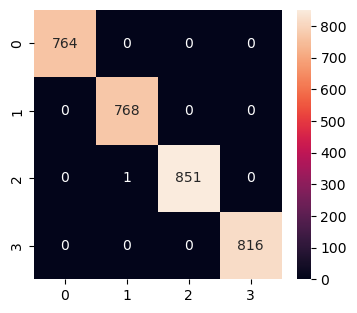

In [212]:
plt.subplots(figsize=(4,3.5))
sns.heatmap(confusion_matrix(y_true_train, y_pred_class_train), annot=True, fmt=".0f");
plt.show()

In [213]:
y_true_train

array([2, 0, 2, ..., 0, 1, 3], dtype=int32)

In [247]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(y_true_train),
                                    y=y_true_train)
class_weight

#class_train=[1321, 1339, 1595, 1457]

array([1.0925    , 1.07107843, 0.80925926, 1.0925    ])

In [248]:
class_weight_dict = { i : class_weight[i] for i in range(0, len(class_weight) ) }
class_weight_dict

{0: 1.0925, 1: 1.071078431372549, 2: 0.8092592592592592, 3: 1.0925}

In [233]:
new_model_bal = Sequential()
new_model_bal.add(conv_model)
new_model_bal.add(tf.keras.layers.GlobalAveragePooling2D())
new_model_bal.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [234]:
new_model_bal.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [251]:
%%time
history_2 = new_model_bal.fit(
                            train_ds,
                            epochs = 20,
                            validation_data = val_ds,
                            class_weight = class_weight_dict,
                            callbacks=[checkpoint]
                            )

Epoch 1/20


2024-04-04 14:44:06.510388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/model_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 79s 188ms/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.1113 - val_sparse_categorical_accuracy: 0.9676
Epoch 2/20
143/143 [==============================] - 25s 174ms/step - loss: 0.0093 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.1162 - val_sparse_categorical_accuracy: 0.9702
Epoch 3/20
143/143 [==============================] - 26s 179ms/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.1611 - val_sparse_categorical_accuracy: 0.9562
Epoch 4/20
143/143 [==============================] - 25s 173ms/step - loss: 0.0161 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.1370 - val_sparse_categorical_accuracy: 0.9685
Epoch 5/20
143/143 [==============================] - 25s 173ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0937 - val_sparse_categorical_accuracy: 0.9755
Epoch 6/20
143/143 [==============================] - 25s 173ms/step - loss: 0.0037 - sparse_cat

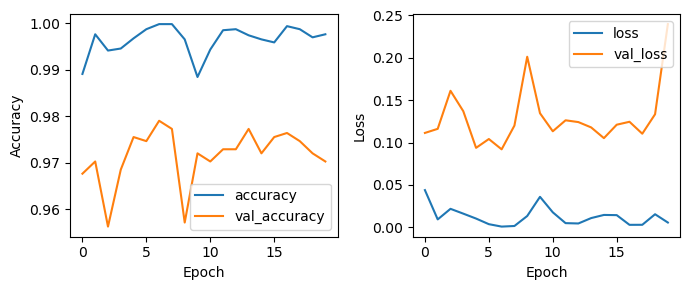

In [252]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_2.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_2.history['loss'], label='loss')
ax[1].plot(history_2.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.show()

In [253]:
y_true_bal, y_pred_bal = eval_model_on_test(new_model_bal)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:00<00:05,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:00<00:03,  2.77it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:00<00:02,  3.49it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:01<00:01,  3.98it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:01<00:01,  4.32it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:01<00:01,  4.55it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:01<00:00,  4.71it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:01<00:00,  4.81it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:02<00:00,  4.90it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:02<00:00,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.48it/s]


In [255]:
y_pred_class_bal = np.argmax(y_pred_bal,1)
print(classification_report(y_true_bal, y_pred_class_bal, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.96      0.98      0.97       300
  meningioma       0.96      0.97      0.97       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.96      0.97       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



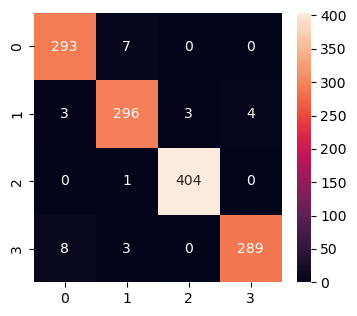

In [256]:
plt.subplots(figsize=(4,3.5))
sns.heatmap(confusion_matrix(y_true_bal, y_pred_class_bal), annot=True, fmt=".0f");
plt.show()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

## Apply data augmentation before training the elasticnet model

In [303]:
def prepare_train_and_val_datasets_w_aug():
    train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds_aug = (train_ds_aug.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.4), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=25))
    
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds_aug, val_ds

In [259]:
train_ds_aug, val_ds = prepare_train_and_val_datasets_w_aug()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [264]:
new_model_aug = Sequential()
new_model_aug.add(conv_model)
new_model_aug.add(tf.keras.layers.GlobalAveragePooling2D())
new_model_aug.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [265]:
new_model_aug.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [266]:
%%time
history_3 = new_model_aug.fit(
                            train_ds_aug,
                            epochs = 10,
                            validation_data = val_ds,
                            class_weight = class_weight_dict,
                            callbacks=[checkpoint]
                            )

Epoch 1/10


2024-04-04 15:12:39.023719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/model_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - ETA: 0s - loss: 0.0619 - sparse_categorical_accuracy: 0.9853

2024-04-04 15:13:30.399362: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 86s 220ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0822 - val_sparse_categorical_accuracy: 0.9755
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 0.0225 - sparse_categorical_accuracy: 0.9923

2024-04-04 15:13:58.530089: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 172ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.0976 - val_sparse_categorical_accuracy: 0.9729
Epoch 3/10
143/143 [==============================] - ETA: 0s - loss: 0.0208 - sparse_categorical_accuracy: 0.9945

2024-04-04 15:14:24.309069: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0851 - val_sparse_categorical_accuracy: 0.9755
Epoch 4/10
143/143 [==============================] - ETA: 0s - loss: 0.0107 - sparse_categorical_accuracy: 0.9967

2024-04-04 15:14:50.151769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0107 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0997 - val_sparse_categorical_accuracy: 0.9746
Epoch 5/10
143/143 [==============================] - ETA: 0s - loss: 0.0141 - sparse_categorical_accuracy: 0.9965

2024-04-04 15:15:16.054064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 172ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0846 - val_sparse_categorical_accuracy: 0.9799
Epoch 6/10
143/143 [==============================] - ETA: 0s - loss: 0.0185 - sparse_categorical_accuracy: 0.9945

2024-04-04 15:15:42.138014: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 27s 181ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0696 - val_sparse_categorical_accuracy: 0.9807
Epoch 7/10
143/143 [==============================] - ETA: 0s - loss: 0.0142 - sparse_categorical_accuracy: 0.9947

2024-04-04 15:16:09.007951: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.1344 - val_sparse_categorical_accuracy: 0.9676
Epoch 8/10
143/143 [==============================] - ETA: 0s - loss: 0.0167 - sparse_categorical_accuracy: 0.9952

2024-04-04 15:16:34.695243: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0889 - val_sparse_categorical_accuracy: 0.9746
Epoch 9/10
143/143 [==============================] - ETA: 0s - loss: 0.0139 - sparse_categorical_accuracy: 0.9956

2024-04-04 15:17:00.578087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 172ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0789 - val_sparse_categorical_accuracy: 0.9799
Epoch 10/10
143/143 [==============================] - ETA: 0s - loss: 0.0041 - sparse_categorical_accuracy: 0.9991

2024-04-04 15:17:26.434816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0963 - val_sparse_categorical_accuracy: 0.9851
CPU times: user 5min 28s, sys: 1min 8s, total: 6min 36s
Wall time: 5min 20s


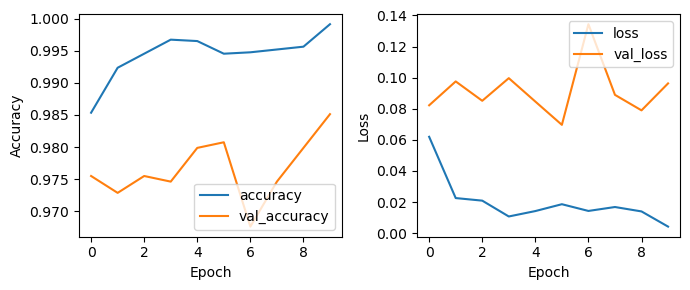

In [267]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_3.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_3.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_3.history['loss'], label='loss')
ax[1].plot(history_3.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.show()

In [268]:
y_true_aug, y_pred_aug = eval_model_on_test(new_model_aug)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 3s 116ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:03<00:30,  3.05s/it]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:03<00:12,  1.38s/it]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:03<00:06,  1.19it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:03<00:04,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:03<00:02,  2.21it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:04<00:01,  2.72it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:04<00:01,  3.18it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:04<00:00,  3.60it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:04<00:00,  3.95it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:04<00:00,  4.20it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.45it/s]


In [269]:
y_pred_class_aug = np.argmax(y_pred_aug,1)
print(classification_report(y_true_aug, y_pred_class_aug, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.97      0.97      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



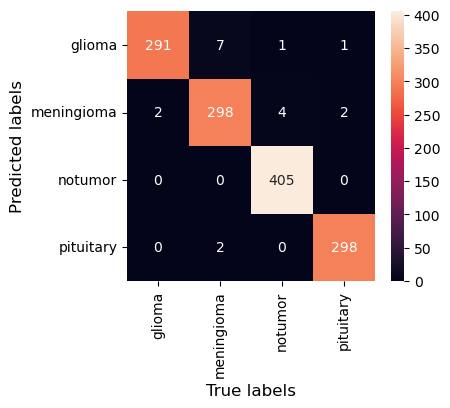

In [298]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_aug, y_pred_class_aug),
            annot=True,
            fmt=".0f",
            xticklabels=class_names,
            yticklabels=class_names
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.show()

In [279]:
#new_model_aug.save_weights('./model_weights/new_model_aug')

## Try Model with manually choosing class weights

In [304]:
class_weight_man = [2, 2, 0.5, 1]

In [305]:
class_weight_dict_manual = { i : class_weight_man[i] for i in range(0, len(class_weight_man) ) }
class_weight_dict_manual

{0: 2, 1: 2, 2: 0.5, 3: 1}

In [306]:
new_model_man = Sequential()
new_model_man.add(conv_model)
new_model_man.add(tf.keras.layers.GlobalAveragePooling2D())
new_model_man.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [308]:
new_model_man.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [309]:
%%time
history_4 = new_model_man.fit(
                            train_ds_aug,
                            epochs = 20,
                            validation_data = val_ds,
                            class_weight = class_weight_dict_manual,
                            callbacks=[checkpoint]
                            )

Epoch 1/20


2024-04-04 15:44:58.336747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/model_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - ETA: 0s - loss: 0.0408 - sparse_categorical_accuracy: 0.9939

2024-04-04 15:45:47.776141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 83s 189ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.1223 - val_sparse_categorical_accuracy: 0.9702
Epoch 2/20
143/143 [==============================] - ETA: 0s - loss: 0.0309 - sparse_categorical_accuracy: 0.9939

2024-04-04 15:46:13.663947: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0309 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.1333 - val_sparse_categorical_accuracy: 0.9641
Epoch 3/20
143/143 [==============================] - ETA: 0s - loss: 0.0216 - sparse_categorical_accuracy: 0.9952

2024-04-04 15:46:39.688609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.1187 - val_sparse_categorical_accuracy: 0.9755
Epoch 4/20
143/143 [==============================] - ETA: 0s - loss: 0.0064 - sparse_categorical_accuracy: 0.9985

2024-04-04 15:47:05.650256: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0833 - val_sparse_categorical_accuracy: 0.9816
Epoch 5/20
143/143 [==============================] - ETA: 0s - loss: 0.0120 - sparse_categorical_accuracy: 0.9980

2024-04-04 15:47:31.837977: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0120 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1058 - val_sparse_categorical_accuracy: 0.9807
Epoch 6/20
143/143 [==============================] - ETA: 0s - loss: 0.0064 - sparse_categorical_accuracy: 0.9989

2024-04-04 15:47:57.536085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.1073 - val_sparse_categorical_accuracy: 0.9816
Epoch 7/20
143/143 [==============================] - ETA: 0s - loss: 0.0089 - sparse_categorical_accuracy: 0.9982

2024-04-04 15:48:23.189076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0952 - val_sparse_categorical_accuracy: 0.9825
Epoch 8/20
143/143 [==============================] - ETA: 0s - loss: 0.0025 - sparse_categorical_accuracy: 0.9991

2024-04-04 15:48:48.805315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1022 - val_sparse_categorical_accuracy: 0.9825
Epoch 9/20
143/143 [==============================] - ETA: 0s - loss: 0.0062 - sparse_categorical_accuracy: 0.9978

2024-04-04 15:49:14.454973: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.1396 - val_sparse_categorical_accuracy: 0.9790
Epoch 10/20
143/143 [==============================] - ETA: 0s - loss: 0.0326 - sparse_categorical_accuracy: 0.9939

2024-04-04 15:49:40.031443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.1028 - val_sparse_categorical_accuracy: 0.9807
Epoch 11/20
143/143 [==============================] - ETA: 0s - loss: 0.0222 - sparse_categorical_accuracy: 0.9947

2024-04-04 15:50:05.668700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.1060 - val_sparse_categorical_accuracy: 0.9799
Epoch 12/20
143/143 [==============================] - ETA: 0s - loss: 0.0123 - sparse_categorical_accuracy: 0.9978

2024-04-04 15:50:31.681255: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0919 - val_sparse_categorical_accuracy: 0.9790
Epoch 13/20
143/143 [==============================] - ETA: 0s - loss: 0.0064 - sparse_categorical_accuracy: 0.9985

2024-04-04 15:50:57.917697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.1148 - val_sparse_categorical_accuracy: 0.9764
Epoch 14/20
143/143 [==============================] - ETA: 0s - loss: 0.0017 - sparse_categorical_accuracy: 0.9996

2024-04-04 15:51:23.886083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 172ms/step - loss: 0.0017 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.1034 - val_sparse_categorical_accuracy: 0.9816
Epoch 15/20
143/143 [==============================] - ETA: 0s - loss: 0.0029 - sparse_categorical_accuracy: 0.9991

2024-04-04 15:51:49.606733: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0029 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1019 - val_sparse_categorical_accuracy: 0.9842
Epoch 16/20
143/143 [==============================] - ETA: 0s - loss: 0.0140 - sparse_categorical_accuracy: 0.9958

2024-04-04 15:52:15.670551: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.1172 - val_sparse_categorical_accuracy: 0.9729
Epoch 17/20
143/143 [==============================] - ETA: 0s - loss: 0.0456 - sparse_categorical_accuracy: 0.9895

2024-04-04 15:52:41.458478: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.1338 - val_sparse_categorical_accuracy: 0.9694
Epoch 18/20
143/143 [==============================] - ETA: 0s - loss: 0.0520 - sparse_categorical_accuracy: 0.9884

2024-04-04 15:53:07.112574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.1084 - val_sparse_categorical_accuracy: 0.9755
Epoch 19/20
143/143 [==============================] - ETA: 0s - loss: 0.0187 - sparse_categorical_accuracy: 0.9943

2024-04-04 15:53:33.060557: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 172ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.1204 - val_sparse_categorical_accuracy: 0.9755
Epoch 20/20
143/143 [==============================] - ETA: 0s - loss: 0.0189 - sparse_categorical_accuracy: 0.9958

2024-04-04 15:53:59.327084: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 176ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0713 - val_sparse_categorical_accuracy: 0.9816
CPU times: user 10min 9s, sys: 1min 57s, total: 12min 6s
Wall time: 9min 34s


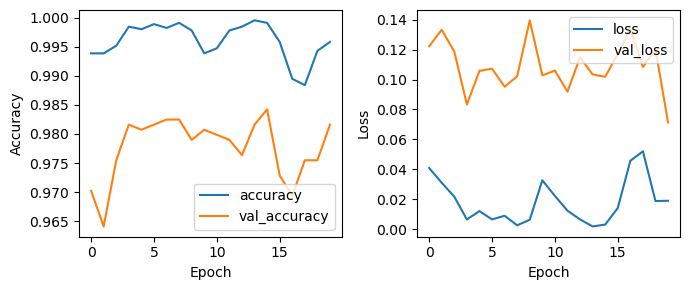

In [310]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_4.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_4.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_4.history['loss'], label='loss')
ax[1].plot(history_4.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.show()

In [311]:
y_true_man, y_pred_man = eval_model_on_test(new_model_man)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 3s 96ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:02<00:29,  2.90s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:03<00:11,  1.32s/it]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:03<00:06,  1.24it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:03<00:03,  1.76it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:03<00:02,  2.28it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:03<00:01,  2.81it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:04<00:01,  3.27it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:04<00:00,  3.70it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:04<00:00,  4.04it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:04<00:00,  4.31it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.50it/s]


In [312]:
y_pred_class_man = np.argmax(y_pred_man,1)
print(classification_report(y_true_man, y_pred_class_man, target_names=class_names))

              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.95      0.99      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



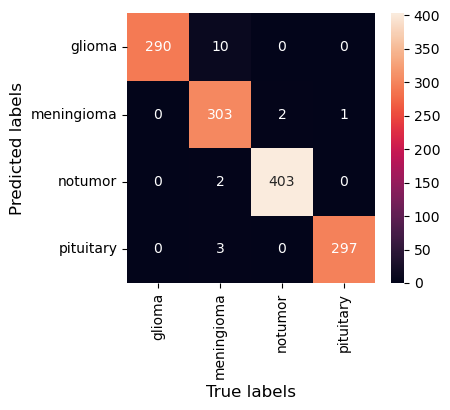

In [313]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_man, y_pred_class_man),
            annot=True,
            fmt=".0f",
            xticklabels=class_names,
            yticklabels=class_names
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.show()

## Train best model with all training data

In [316]:
def prepare_only_train_w_aug():
    train_ds_only = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=16,
    )


    train_ds_only = (train_ds_only.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.4), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=25))

    return train_ds_only

In [317]:
train_ds_only = prepare_only_train_w_aug()

Found 5712 files belonging to 4 classes.


In [319]:
history_5 = new_model_aug.fit(
                            train_ds_only,
                            epochs = 20,
                            validation_data = val_ds,
                            class_weight = class_weight_dict,
                            callbacks=[checkpoint]
                            )

Epoch 1/20
357/357 [==============================] - ETA: 0s - loss: 0.0154 - sparse_categorical_accuracy: 0.9956

2024-04-04 16:10:10.040803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 119ms/step - loss: 0.0154 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0132 - val_sparse_categorical_accuracy: 0.9956
Epoch 2/20
  1/357 [..............................] - ETA: 11:55 - loss: 0.0246 - sparse_categorical_accuracy: 1.0000

2024-04-04 16:10:13.342668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78644800 bytes after encountering the first element of size 3145792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - ETA: 0s - loss: 0.0201 - sparse_categorical_accuracy: 0.9939

2024-04-04 16:10:55.675200: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 46s 122ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0284 - val_sparse_categorical_accuracy: 0.9912
Epoch 3/20
  1/357 [..............................] - ETA: 12:17 - loss: 5.2363e-04 - sparse_categorical_accuracy: 1.0000

2024-04-04 16:10:59.024304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78644800 bytes after encountering the first element of size 3145792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - ETA: 0s - loss: 0.0186 - sparse_categorical_accuracy: 0.9953

2024-04-04 16:11:39.797017: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 44s 118ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0283 - val_sparse_categorical_accuracy: 0.9912
Epoch 4/20
  1/357 [..............................] - ETA: 12:27 - loss: 1.6837e-04 - sparse_categorical_accuracy: 1.0000

2024-04-04 16:11:43.170632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78644800 bytes after encountering the first element of size 3145792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - ETA: 0s - loss: 0.0329 - sparse_categorical_accuracy: 0.9914

2024-04-04 16:12:23.680338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 121ms/step - loss: 0.0329 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0073 - val_sparse_categorical_accuracy: 0.9982
Epoch 5/20
357/357 [==============================] - ETA: 0s - loss: 0.0332 - sparse_categorical_accuracy: 0.9919

2024-04-04 16:13:09.378933: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 44s 119ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.0216 - val_sparse_categorical_accuracy: 0.9947
Epoch 6/20
357/357 [==============================] - ETA: 0s - loss: 0.0200 - sparse_categorical_accuracy: 0.9937

2024-04-04 16:13:54.908277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 46s 123ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0128 - val_sparse_categorical_accuracy: 0.9965
Epoch 7/20
357/357 [==============================] - ETA: 0s - loss: 0.0112 - sparse_categorical_accuracy: 0.9961

2024-04-04 16:14:40.823107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 46s 123ms/step - loss: 0.0112 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0106 - val_sparse_categorical_accuracy: 0.9982
Epoch 8/20
  1/357 [..............................] - ETA: 12:22 - loss: 0.0034 - sparse_categorical_accuracy: 1.0000

2024-04-04 16:14:44.240826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78644800 bytes after encountering the first element of size 3145792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - ETA: 0s - loss: 0.0162 - sparse_categorical_accuracy: 0.9949

2024-04-04 16:15:26.005031: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 121ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0257 - val_sparse_categorical_accuracy: 0.9930
Epoch 9/20
  1/357 [..............................] - ETA: 12:25 - loss: 0.0021 - sparse_categorical_accuracy: 1.0000

2024-04-04 16:15:29.398515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78644800 bytes after encountering the first element of size 3145792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - ETA: 0s - loss: 0.0140 - sparse_categorical_accuracy: 0.9965

2024-04-04 16:16:11.070443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 46s 123ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0071 - val_sparse_categorical_accuracy: 0.9982
Epoch 10/20
357/357 [==============================] - ETA: 0s - loss: 0.0187 - sparse_categorical_accuracy: 0.9956

2024-04-04 16:16:56.651602: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 119ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0154 - val_sparse_categorical_accuracy: 0.9947
Epoch 11/20
357/357 [==============================] - ETA: 0s - loss: 0.0138 - sparse_categorical_accuracy: 0.9956

2024-04-04 16:17:41.572136: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 120ms/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0165 - val_sparse_categorical_accuracy: 0.9947
Epoch 12/20
357/357 [==============================] - ETA: 0s - loss: 0.0135 - sparse_categorical_accuracy: 0.9967

2024-04-04 16:18:26.416763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 120ms/step - loss: 0.0135 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0080 - val_sparse_categorical_accuracy: 0.9974
Epoch 13/20
357/357 [==============================] - ETA: 0s - loss: 0.0232 - sparse_categorical_accuracy: 0.9925

2024-04-04 16:19:11.898053: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 122ms/step - loss: 0.0232 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.0389 - val_sparse_categorical_accuracy: 0.9912
Epoch 14/20
357/357 [==============================] - ETA: 0s - loss: 0.0162 - sparse_categorical_accuracy: 0.9949

2024-04-04 16:19:58.238904: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 46s 124ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0099 - val_sparse_categorical_accuracy: 0.9982
Epoch 15/20
357/357 [==============================] - ETA: 0s - loss: 0.0099 - sparse_categorical_accuracy: 0.9981

2024-04-04 16:20:44.363987: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 46s 123ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0238 - val_sparse_categorical_accuracy: 0.9921
Epoch 16/20
357/357 [==============================] - ETA: 0s - loss: 0.0262 - sparse_categorical_accuracy: 0.9928

2024-04-04 16:21:29.753433: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 121ms/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.0088 - val_sparse_categorical_accuracy: 0.9965
Epoch 17/20
357/357 [==============================] - ETA: 0s - loss: 0.0167 - sparse_categorical_accuracy: 0.9949

2024-04-04 16:22:16.722331: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 47s 126ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0099 - val_sparse_categorical_accuracy: 0.9974
Epoch 18/20
357/357 [==============================] - ETA: 0s - loss: 0.0105 - sparse_categorical_accuracy: 0.9968

2024-04-04 16:23:02.048981: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 47s 125ms/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0055 - val_sparse_categorical_accuracy: 0.9982
Epoch 19/20
357/357 [==============================] - ETA: 0s - loss: 0.0087 - sparse_categorical_accuracy: 0.9974

2024-04-04 16:23:47.800568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 46s 122ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0027 - val_sparse_categorical_accuracy: 0.9991
Epoch 20/20
357/357 [==============================] - ETA: 0s - loss: 0.0068 - sparse_categorical_accuracy: 0.9981

2024-04-04 16:24:33.990896: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


357/357 [==============================] - 45s 121ms/step - loss: 0.0068 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0038 - val_sparse_categorical_accuracy: 0.9991


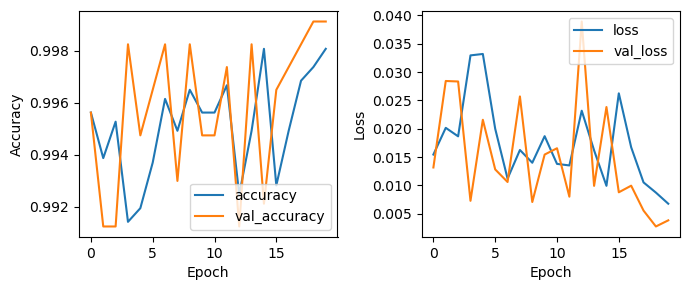

In [320]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_5.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_5.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_5.history['loss'], label='loss')
ax[1].plot(history_5.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.show()

In [321]:
y_true_final, y_pred_final = eval_model_on_test(new_model_aug)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 142ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:00<00:07,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:00<00:04,  2.23it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:01<00:02,  2.88it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:01<00:02,  3.33it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:01<00:01,  3.60it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:01<00:01,  3.81it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:02<00:01,  3.86it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:02<00:00,  3.99it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:02<00:00,  4.06it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:02<00:00,  4.11it/s]

1/1 [==============================] - 0s 71ms/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.65it/s]


In [322]:
y_pred_class_final = np.argmax(y_pred_final,1)
print(classification_report(y_true_final, y_pred_class_final, target_names=class_names))

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



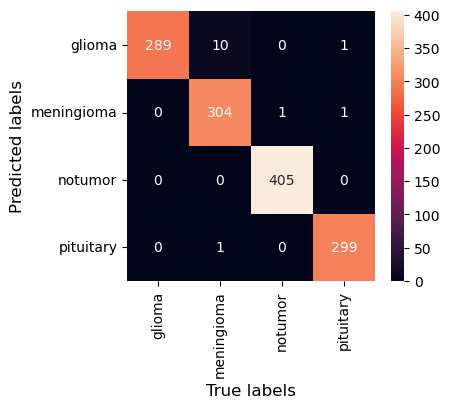

In [323]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_final, y_pred_class_final),
            annot=True,
            fmt=".0f",
            xticklabels=class_names,
            yticklabels=class_names
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.show()

In [325]:
#new_model_aug.save_weights('./model_weights/new_model_final')

Text(0.5, 1.0, '2')

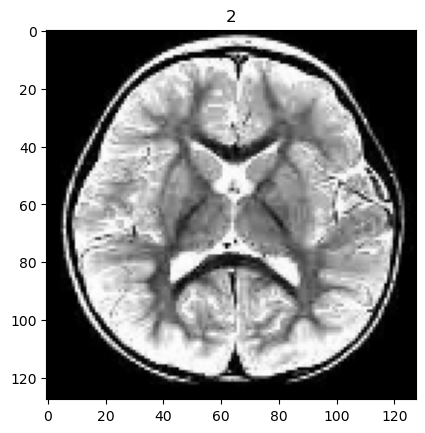

In [281]:
plt.imshow(images[0].numpy().astype("uint8"))
plt.title(int(labels[0]))

In [284]:
!pip install opencv-python

In [288]:
import cv2

ImportError: libGL.so.1: cannot open shared object file: No such file or directory